### **Imports**

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
from sklearn import model_selection
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.utils import shuffle

#from tensorflow.keras.applications.imagenet_utils import preprocess_input
#from keras.applications.vgg16 import preprocess_input, decode_prediction
from tensorflow.keras.regularizers import *
# TensorFlow session: grow memory when needed. TF, DO NOT USE ALL MY GPU MEMORY!!!
'''
gpu_options = tf.GPUOptions(allow_growth=True)
config = tf.ConfigProto(log_device_placement=False, gpu_options=gpu_options)
isess = tf.InteractiveSession(config=config)
'''
tf.compat.v1.disable_eager_execution()
config = tf.compat.v1.ConfigProto()
#config.gpu_options.per_process_gpu_memory_fraction = 0.2
config.gpu_options.allow_growth=True
sess = tf.compat.v1.Session(config=config)



### **Mount & set directory**


In [0]:
home_dir = '..\\'
baum_dir = home_dir + 'BAUM\\'

data = pd.read_csv(baum_dir + 'training_data_1s.csv', dtype={'flow': str, 'spatial': str, 'code': str})
data_valid = pd.read_csv(baum_dir + 'validation_data_1s.csv', dtype={'flow': str, 'spatial': str, 'code': str})

data = shuffle(data)
data_valid = shuffle(data_valid)
'''
print("Original data", len(data),  len(data_valid))
def sampling_k_elements(group, k=4000):
    if len(group) < k:
        return group
    return group.sample(k)

def sampling_k_elements_valid(group, k=1000):
    if len(group) < k:
        return group
    return group.sample(k)

data = data.groupby('code').apply(sampling_k_elements).reset_index(drop=True)
data_valid = data_valid.groupby('code').apply(sampling_k_elements_valid).reset_index(drop=True)
print("Less data", len(data),  len(data_valid))

data = shuffle(data)
data_valid = shuffle(data_valid)
#ax3 = data['code'].plot.hist(bins=12)
'''

'\nprint("Original data", len(data),  len(data_valid))\ndef sampling_k_elements(group, k=4000):\n    if len(group) < k:\n        return group\n    return group.sample(k)\n\ndef sampling_k_elements_valid(group, k=1000):\n    if len(group) < k:\n        return group\n    return group.sample(k)\n\ndata = data.groupby(\'code\').apply(sampling_k_elements).reset_index(drop=True)\ndata_valid = data_valid.groupby(\'code\').apply(sampling_k_elements_valid).reset_index(drop=True)\nprint("Less data", len(data),  len(data_valid))\n\ndata = shuffle(data)\ndata_valid = shuffle(data_valid)\n#ax3 = data[\'code\'].plot.hist(bins=12)\n'

In [0]:
data.head()

,flow,spatial,emotion,code
37345,imgs_flow\s022\S022_060\068.png,imgs_spatial\s022\S022_060\068.png,Disgust,2
5065,imgs_flow\s003\S003_017\113.png,imgs_spatial\s003\S003_017\113.png,Happiness,4
28382,imgs_flow\s019\S019_051\024.png,imgs_spatial\s019\S019_051\024.png,Sadness,5
30029,imgs_flow\s019\S019_070\018.png,imgs_spatial\s019\S019_070\018.png,Disgust,2
7966,imgs_flow\s004\S004_023\050.png,imgs_spatial\s004\S004_023\050.png,Happiness,4


### **Data Analysis and Visualization**

Unique classes are:  ['2', '4', '5', '6', '1', '3']
..\BAUM\imgs_spatial\s002\S002_049\045.png
..\BAUM\imgs_spatial\s002\S002_038\629.png
..\BAUM\imgs_spatial\s018\S018_022\007.png
..\BAUM\imgs_spatial\s003\S003_027\135.png
..\BAUM\imgs_spatial\s031\S031_043\095.png
..\BAUM\imgs_spatial\s004\S004_028\341.png
..\BAUM\imgs_spatial\s010\S010_065\071.png
..\BAUM\imgs_spatial\s020\S020_046\047.png
..\BAUM\imgs_spatial\s012\S012_014\020.png
..\BAUM\imgs_spatial\s021\S021_091\077.png


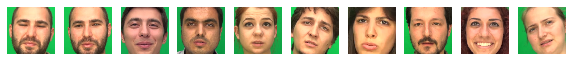

['Disgust', 'Happiness', 'Happiness', 'Sadness', 'Sadness', 'Sadness', 'Disgust', 'Anger', 'Happiness', 'Disgust']


In [0]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
data_unique = data['code'].unique().tolist()
print("Unique classes are: ",data_unique)

images = []
images_flow = []
emotions = []
codes = []
i = 0
while i < 10:
  
  sample = data.sample()
  spatial = sample['spatial'] 
  emotion = sample['emotion'] 
  code = sample['code']

  spatial = spatial.values[0]
  emotion = emotion.values[0]
  code = code.values[0]

  img_path = baum_dir + spatial
  print (img_path)
  if (os.path.isfile(img_path)):
    images.append(mpimg.imread(img_path))
    emotions.append(emotion)
    codes.append(code)
    i+=1

plt.figure(figsize=(10,15))
columns = 10

for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image)
    plt.axis('off')
    
plt.show()
print(emotions)

### **Image generators**

In [0]:
train_df, valid_df = data , data_valid

batch_size_ = 256

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator_spatial = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        seed = 1,
        directory=baum_dir,
        x_col="spatial",
        y_col="code",
        target_size=(48, 48),
        batch_size=batch_size_,
        class_mode='categorical',
        shuffle = False)

validation_generator_spatial = test_datagen.flow_from_dataframe(
        dataframe=valid_df,
        seed = 1,
        directory=baum_dir,
        x_col="spatial",
        y_col="code",
        target_size=(48, 48),
        batch_size=batch_size_,
        class_mode='categorical',
        shuffle = False)

train_generator_flow = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        seed = 1,
        directory=baum_dir,
        x_col="flow",
        y_col="code",
        target_size=(48, 48),
        batch_size=batch_size_,
        class_mode='categorical',
        shuffle = False)

validation_generator_flow = test_datagen.flow_from_dataframe(
        dataframe=valid_df,
        seed = 1,
        directory=baum_dir,
        x_col="flow",
        y_col="code",
        target_size=(48, 48),
        batch_size=batch_size_,
        class_mode='categorical',
        shuffle = False)

def combine_generator(gen1, gen2):
    while True:    
        X1i = gen1.next()
        X2i = gen2.next()
        frame = X1i[0][0]
        #cv2.imwrite( str(X1i[1][0]) +".png",frame )
        #cv2.imwrite("f.png", X2i[0][0])
        yield [X1i[0], X2i[0]], X1i[1]  #X1i[1] is the label


train_generator = combine_generator(train_generator_spatial, train_generator_flow)
validation_generator = combine_generator(validation_generator_spatial, validation_generator_flow)

validation_generator_spatial_2 = test_datagen.flow_from_dataframe(
        dataframe=valid_df,
        seed = 1,
        directory=baum_dir,
        x_col="spatial",
        y_col="code",
        target_size=(48, 48),
        batch_size=batch_size_,
        class_mode='categorical',
        shuffle = False)

print ("generators initiaized")


Found 47169 validated image filenames belonging to 6 classes.
Found 7514 validated image filenames belonging to 6 classes.
Found 47169 validated image filenames belonging to 6 classes.
Found 7514 validated image filenames belonging to 6 classes.
Found 7514 validated image filenames belonging to 6 classes.
generators initiaized


### **Model & setting**

In [2]:
def create_model():
    input_spatial = Input(shape=(48,48,3))
    x = layers.Conv2D(128, (5, 5), activation='relu')(input_spatial)
    x = layers.MaxPooling2D(pool_size=(5,5), strides=(2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.AveragePooling2D(pool_size=(3,3), strides=(2, 2))(x)
    x = layers.Conv2D(256, (3, 3), activation='relu')(x)
    x = layers.Conv2D(256, (3, 3), activation='relu')(x)
    #Out_spatial = layers.GlobalAveragePooling2D()(x)
    x = layers.AveragePooling2D(pool_size=(3,3), strides=(2, 2))(x)
    Out_spatial = layers.Flatten()(x)

    input_flow = Input(shape=(48,48,3))
    x = layers.Conv2D(128, (5, 5), activation='relu')(input_flow)
    x = layers.MaxPooling2D(pool_size=(5,5), strides=(2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.AveragePooling2D(pool_size=(3,3), strides=(2, 2))(x)
    x = layers.Conv2D(256, (3, 3), activation='relu')(x)
    x = layers.Conv2D(256, (3, 3), activation='relu')(x)
    #Out_flow = layers.GlobalAveragePooling2D()(x)
    x = layers.AveragePooling2D(pool_size=(3,3), strides=(2, 2))(x)
    Out_flow = layers.Flatten()(x)
    merged = Add()([Out_spatial, Out_flow])
    #merged = sum([Out_spatial, Out_flow])

    x = layers.Dense(1024, activation='relu')(merged)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(1024, activation='relu', kernel_regularizer=l2(0.05))(x)
    x = layers.Dropout(0.1)(x)

    Out = layers.Dense(6, activation='softmax')(x)

    model = models.Model(inputs=[input_spatial, input_flow], outputs=[Out])
    return model


model = create_model()
print (model.summary())

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 44, 44, 128)  9728        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 44, 44, 128)  9728        input_2[0][0]                    
_____________

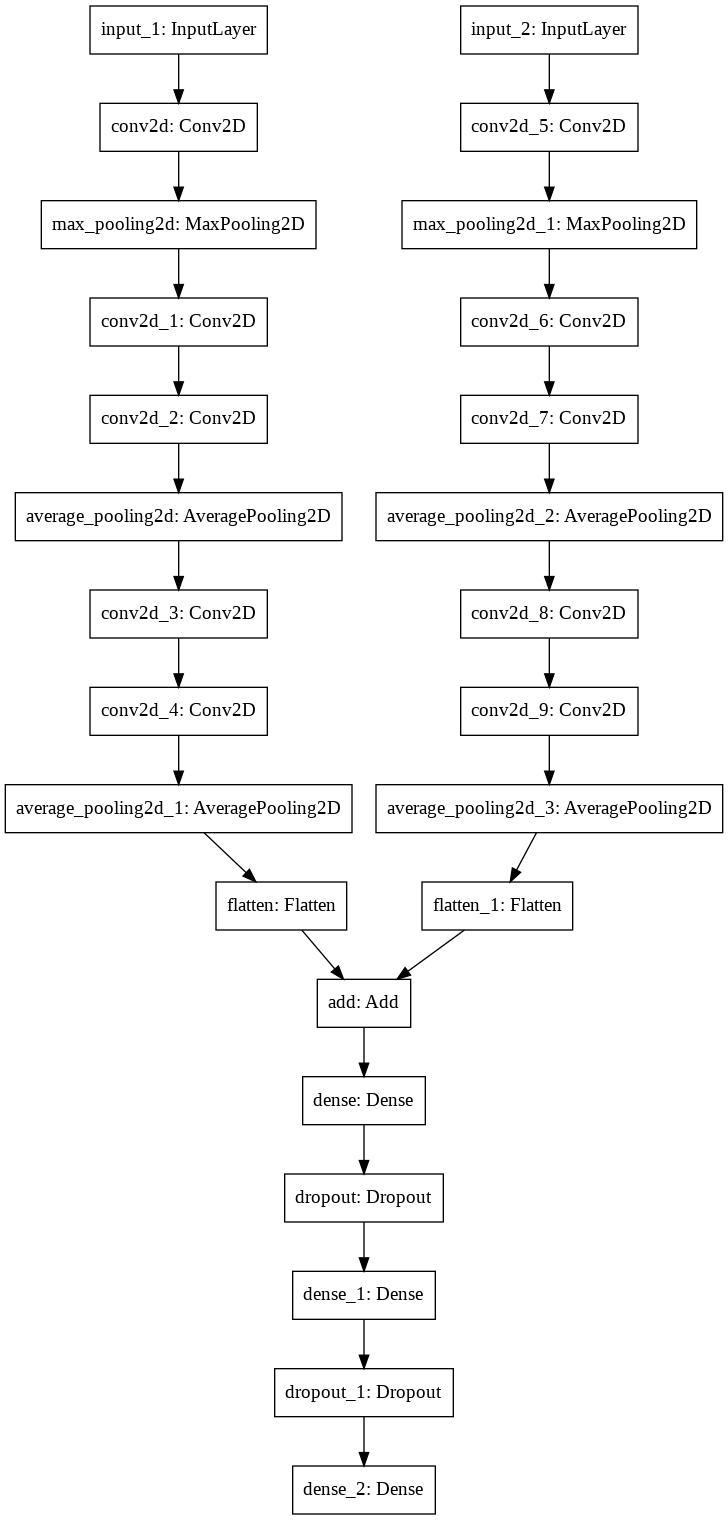

In [3]:
# Plot Model

from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

### **Train**

In [0]:
from tensorflow.keras import optimizers

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=0.00001, rho=0.9),
              metrics=['acc'])

In [0]:
# Auto-save model weights with best val_acc
modelPath  = baum_dir + 'models\\addFlatten.h5'
checkpoint = ModelCheckpoint(modelPath,
                             monitor = 'val_acc',
                             verbose = 1,
                             save_best_only = True,
                             mode = 'max')
callbacks_list = [checkpoint]

# Train The Model
history = model.fit_generator(
        train_generator,
        steps_per_epoch=int(len(train_df) / batch_size_),
        epochs=50,
        #workers=8,
        #use_multiprocessing=True,
        validation_data=validation_generator,
        validation_steps=int(len(valid_df) / batch_size_),
        callbacks = callbacks_list)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
 29/184 [===>..........................] - ETA: 2:56 - loss: 47.6742 - acc: 0.0854
Epoch 00001: val_acc improved from -inf to 0.08540, saving model to ..\BAUM\models\addGAP.h5
184/184 [==============================] - 296s 2s/step - loss: 50.1049 - acc: 0.3511 - val_loss: 47.6742 - val_acc: 0.0854
Epoch 2/50
 29/184 [===>..........................] - ETA: 1:54 - loss: 43.0281 - acc: 0.0854
Epoch 00002: val_acc did not improve from 0.08540
184/184 [==============================] - 219s 1s/step - loss: 45.2247 - acc: 0.3532 - val_loss: 43.0281 - val_acc: 0.0854
Epoch 3/50
 29/184 [===>..........................] - ETA: 1:55 - loss: 38.7059 - acc: 0.0874
Epoch 00003: val_acc improved from 0.08540 to 0.08742, saving model to ..\BAUM\models\addGAP.h5
184/184 [==============================] - 185s 1s/step - loss: 40.7424 - acc: 0.3543 - val_loss: 38.7059 - val_acc: 0.0874
Epoch 4/50
 29/184 [===>.......

 29/184 [===>..........................] - ETA: 1:52 - loss: 3.2058 - acc: 0.5539
Epoch 00021: val_acc did not improve from 0.55630
184/184 [==============================] - 178s 967ms/step - loss: 3.4062 - acc: 0.4825 - val_loss: 3.2058 - val_acc: 0.5539
Epoch 22/50
 29/184 [===>..........................] - ETA: 1:51 - loss: 2.7979 - acc: 0.5640
Epoch 00022: val_acc improved from 0.55630 to 0.56398, saving model to ..\BAUM\models\addGAP.h5
184/184 [==============================] - 178s 967ms/step - loss: 2.9559 - acc: 0.4834 - val_loss: 2.7979 - val_acc: 0.5640
Epoch 23/50
 29/184 [===>..........................] - ETA: 1:51 - loss: 2.5320 - acc: 0.5020
Epoch 00023: val_acc did not improve from 0.56398
184/184 [==============================] - 178s 968ms/step - loss: 2.5952 - acc: 0.4865 - val_loss: 2.5320 - val_acc: 0.5020
Epoch 24/50
 29/184 [===>..........................] - ETA: 1:54 - loss: 2.2386 - acc: 0.5517
Epoch 00024: val_acc did not improve from 0.56398
184/184 [======

Epoch 44/50
 29/184 [===>..........................] - ETA: 1:52 - loss: 1.7173 - acc: 0.3570
Epoch 00044: val_acc did not improve from 0.57961
184/184 [==============================] - 177s 964ms/step - loss: 1.3215 - acc: 0.5451 - val_loss: 1.7173 - val_acc: 0.3570
Epoch 45/50
 29/184 [===>..........................] - ETA: 1:52 - loss: 1.4656 - acc: 0.5238
Epoch 00045: val_acc did not improve from 0.57961
184/184 [==============================] - 177s 964ms/step - loss: 1.3102 - acc: 0.5484 - val_loss: 1.4656 - val_acc: 0.5238
Epoch 46/50
 29/184 [===>..........................] - ETA: 1:51 - loss: 1.6152 - acc: 0.4169
Epoch 00046: val_acc did not improve from 0.57961
184/184 [==============================] - 177s 964ms/step - loss: 1.2992 - acc: 0.5484 - val_loss: 1.6152 - val_acc: 0.4169
Epoch 47/50
 29/184 [===>..........................] - ETA: 1:52 - loss: 1.5487 - acc: 0.4601
Epoch 00047: val_acc did not improve from 0.57961
184/184 [==============================] - 178s 9

### **End**

In [0]:
print(history.history.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


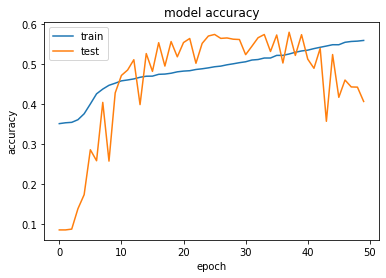

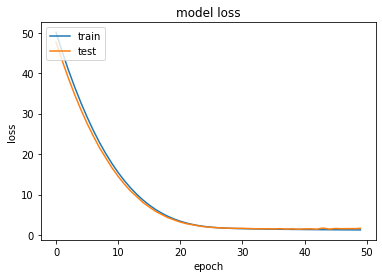

In [0]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

model_path  = baum_dir + 'models\\addFlatten.h5'

# load and evaluate a saved model
model = load_model(model_path)


P = model.predict_generator(generator=validation_generator,
                                   max_queue_size =5,
                                   verbose=1,
                                   steps=len(valid_df)//batch_size_)


Instructions for updating:
Please use Model.predict, which supports generators.
29/29 [==============================] - 19s 650ms/step


7424 7424


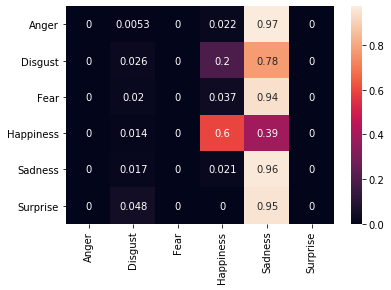

In [0]:
y_predict = np.argmax(P, axis=1)

y_true = validation_generator_spatial_2.classes[:len(y_predict)]

print(len(y_predict), len(y_true))
cm = confusion_matrix(y_true, y_predict)

lables = ['Anger' , 'Disgust' , 'Fear' , 'Happiness', 'Sadness', 'Surprise']
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.heatmap(cmn, annot=True, xticklabels=lables, yticklabels=lables)

In [0]:
calssifiers =['haarcascade_frontalface_default.xml',
              'haarcascade_frontalface_alt2.xml',
              'haarcascade_frontalcatface_extended.xml',
              'haarcascade_frontalcatface.xml',
              'haarcascade_frontalface_alt_tree.xml',
              'haarcascade_frontalface_alt.xml']

def detectFace(img):
    for classifier in calssifiers:
        face_cascade = cv2.CascadeClassifier(home_dir +'face_detectors/' + classifier)
        faces = face_cascade.detectMultiScale(img, 1.3, 1)
        if (len(faces) > 0):
            return faces
    faces = []
    return faces

In [0]:
import cv2
import numpy as np
from glob import glob
import pandas as pd
from random import randint
from random import seed
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from IPython import display
import os

#seed(2)
temp_image = np.array([])
none_image = None

videos = glob(baum_dir+'BAUM1s_MP4 - All\\*\\*.mp4')
emotions = ['Anger', 'Sadness', 'Surprise', 'Disgust', 'Fear', 'Happiness']

data_labels_xl =  pd.read_excel(baum_dir + "Annotations_BAUM1s.xlsx")
data_labels = np.array(data_labels_xl)

#print (vid)
# Assert Video Code
val = randint(0, len(videos)-1)
#print (len(videos))
vid = videos[val]
vidName = vid.split('\\')[-1].split('.')[0]
vidLabel = str(data_labels_xl.loc[data_labels_xl['Clip Name'] == vidName]['Emotion'].values[0])
vidCode = int(data_labels_xl.loc[data_labels_xl['Clip Name'] == vidName]['Emotion Code'].values[0])

while vidCode not in ([1, 10, 11, 6, 7, 8]):
  val = randint(0, len(videos))
  vid = videos[val]
  vidName = vid.split('\\')[-1].split('.')[0]
  #print (vidName)
  try:
    vidLabel = str(data_labels_xl.loc[data_labels_xl['Clip Name'] == vidName]['Emotion'].values[0])
    vidCode = int(data_labels_xl.loc[data_labels_xl['Clip Name'] == vidName]['Emotion Code'].values[0])
  except:
    print ("Video Emotion Not Found")
print ('Video Name: {} Label: {}'.format(vidName, vidLabel))

video_output = baum_dir +'output.mp4'
cap = cv2.VideoCapture(vid)
frameCount = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))  
ret, old_frame = cap.read()
old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
old_gray = cv2.resize(old_gray, (100,100))

clip = VideoFileClip(vid)

count_frames = 0
calcOpticalFlow = -1
def process_image_challenge(frame):
  global calcOpticalFlow, old_gray, count_frames
  count_frames += 1
  #if isinstance(frame, type(temp_image)) and not isinstance(frame, type(none_image)) :
  frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
  faces = detectFace(frame_gray)
  if len(faces) == 0:
      calcOpticalFlow = 0
      print("Old frame due to no faces")
      return frame #return original frame of video

  (x,y,w,h)  = faces[0]
  frame_gray = frame_gray[y:y+h, x:x+w]
  roi_color = frame[y:y+h, x:x+w]

  if(frame_gray.shape[0] < 90 or roi_color.shape[0] < 90 ):
      print("Old frame due to small size")
      calcOpticalFlow = 0
      return frame #return original frame of video

  frame_gray = cv2.resize(frame_gray, (100,100))
  roi_color = cv2.resize(roi_color, (100,100))

  calcOpticalFlow += 1
  hsv = np.zeros_like(roi_color)
  hsv[...,1] = 255

  if (calcOpticalFlow > 1 ):
    flow = cv2.calcOpticalFlowFarneback(old_gray,frame_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)            
    mag, ang   = cv2.cartToPolar(flow[...,0], flow[...,1])
    hsv[...,0] = ang*180/np.pi/2
    hsv[...,2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    
    flowImg = cv2.resize(rgb, (48,48))
    flowImg = flowImg/255.0
    flowImg = flowImg.reshape(-1, 48,48,3)
    roi_color = cv2.cvtColor(roi_color, cv2.COLOR_BGR2RGB)
    spatialImg = cv2.resize(roi_color, (48,48))
    spatialImg = spatialImg/255.0
    spatialImg = spatialImg.reshape(-1, 48,48,3)
    
    out = model.predict([spatialImg, flowImg])
    org = (50, 50)   
    # fontScale 
    fontScale = 1 
    font = cv2.FONT_HERSHEY_SIMPLEX      
    # Blue color in BGR 
    color = (255, 0, 0)   
    # Line thickness of 2 px 
    thickness = 2    
    # Using cv2.putText() method 
    txt = 'Ground Truth: {}, Out: {}'.format(vidLabel, emotions[np.argmax(out[0])])
    #print ('True: {}, Out: {}, Prob.: {}'.format(vidLabel, emotions[np.argmax(out[0])], out[0]))
    frame = cv2.putText(frame, txt, org, font,  
                      fontScale, color, thickness, cv2.LINE_AA) 
 
  old_gray = frame_gray.copy()
  return frame

challenge_clip = clip.fl_image(process_image_challenge)
%time challenge_clip.write_videofile(video_output, audio=False)
print(count_frames , frameCount)
print("The random index is ", val)


Video Name: S001_014 Label: sadness


t:   1%|█▎                                                                                                                                             | 3/327 [00:00<00:12, 26.86it/s, now=None]

Moviepy - Building video ..\BAUM\output.mp4.
Moviepy - Writing video ..\BAUM\output.mp4



t:   5%|███████▍                                                                                                                                      | 17/327 [00:00<00:17, 17.55it/s, now=None]

Old frame due to small size


t:   8%|██████████▊                                                                                                                                   | 25/327 [00:01<00:16, 17.96it/s, now=None]

Old frame due to small size


t:  17%|███████████████████████▉                                                                                                                      | 55/327 [00:03<00:15, 18.00it/s, now=None]

Old frame due to small size


t:  18%|█████████████████████████▌                                                                                                                    | 59/327 [00:03<00:14, 18.56it/s, now=None]

Old frame due to small size
Old frame due to small size


t:  32%|█████████████████████████████████████████████▎                                                                                               | 105/327 [00:05<00:12, 17.88it/s, now=None]

Old frame due to small size


t:  33%|███████████████████████████████████████████████                                                                                              | 109/327 [00:06<00:12, 17.60it/s, now=None]

Old frame due to small size


t:  50%|███████████████████████████████████████████████████████████████████████▏                                                                     | 165/327 [00:09<00:09, 17.68it/s, now=None]

Old frame due to small size


t:  57%|███████████████████████████████████████████████████████████████████████████████▊                                                             | 185/327 [00:10<00:07, 18.01it/s, now=None]

Old frame due to small size
Old frame due to small size


t:  63%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 207/327 [00:11<00:06, 17.43it/s, now=None]

Old frame due to small size


t:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 231/327 [00:13<00:05, 17.21it/s, now=None]

Old frame due to small size
Old frame due to small size


t:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 255/327 [00:14<00:03, 18.01it/s, now=None]

Old frame due to small size
Old frame due to small size


t:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 263/327 [00:15<00:03, 17.64it/s, now=None]

Old frame due to small size


t:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 307/327 [00:17<00:01, 18.25it/s, now=None]

Old frame due to small size


t:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 321/327 [00:18<00:00, 18.29it/s, now=None]

Old frame due to small size


Moviepy - Done !
Moviepy - video ready ..\BAUM\output.mp4
Wall time: 19 s
328 326
The random index is  9


In [0]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open(video_output,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)